In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
import re
from nltk import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
from mlxtend.preprocessing import TransactionEncoder

In [53]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\malon\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [2]:
sns.set(context='paper', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)
plt.rcParams['figure.figsize'] = [20, 10]

## How Tags change over time 
We want to understand if there's is an overall pattern to how tags change over time. Tags may become more popular during certain periods and this is important to understand as there may be tags that overlap (i.e Gore and Horror). We'll use market-basket analysis as well to find out which tags appear together, and then measure how tags are related to genres. 

In [3]:
tags = pd.read_csv('ml-20m/tags.csv')
movies = pd.read_csv('ml-20m/movies.csv')
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


Tags need to be cleaned so we'll remove sepcial characters and lowercase the tags. 

In [4]:
tags['tag'] = tags['tag'].astype(str)
tags['tag'] = tags['tag'].map(lambda x: re.sub(r'\W', ' ', x).lower())
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,mark waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


With both datasets now loadedd, first thing that is needed is obtain the year each movie was released. 

In [6]:
# Split title column into title and year; remove parentheses
for i in range(len(movies)):
    try:
        movies.loc[i, 'releaseYear'] = re.search('\([0-9]*\)', str(movies.loc[i, 'title'])).group(0)
        movies.loc[i, 'releaseYear'] = re.sub('[^0-9]', '', str(movies.loc[i, 'releaseYear']))
        movies.loc[i, 'title'] = re.sub('\([\d]*\)', '', str(movies.loc[i, 'title']))
    except:
        movies.loc[i, 'releaseYear'] = 0
    
movies.head()

,movieId,title,genres,releaseYear
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [7]:
# Drop movies that don't have four digits as their years. 
movies['releaseYear'] = movies.releaseYear.astype(int)
movies = movies[movies['releaseYear']>=1891]

Now that we have the year each movie was released, we can merge the data with the tags dataframe. 

In [8]:
tags_complete = tags.merge(movies, on='movieId', how='left')
tags_complete.head()

,userId,movieId,tag,timestamp,title,genres,releaseYear
0,18,4141,mark waters,1240597180,Head Over Heels,Comedy|Romance,2001.0
1,65,208,dark hero,1368150078,Waterworld,Action|Adventure|Sci-Fi,1995.0
2,65,353,dark hero,1368150079,"Crow, The",Action|Crime|Fantasy|Thriller,1994.0
3,65,521,noir thriller,1368149983,Romeo Is Bleeding,Crime|Thriller,1993.0
4,65,592,dark hero,1368150078,Batman,Action|Crime|Thriller,1989.0


We now want to stem as many tags as possible, reducing unnecessary duplicates.

In [9]:
# Initialize stemmer
porter = PorterStemmer()


# Create function that tokenizes words in string and stems words. 
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

# Stem clean text in df_clean
tags['tag'] = tags['tag'].map(lambda x: stemSentence(x))
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,mark water,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


Now, we want to count the times each tag appears over the year each movie was released.

In [10]:
tag_year_counts = tags_complete.groupby(['releaseYear', 'tag'])['movieId'].count().reset_index()
tag_year_counts.head()

,releaseYear,tag,movieId
0,1893.0,short,1
1,1894.0,dvd video,1
2,1894.0,short,1
3,1895.0,louis lumière,2
4,1895.0,short film,1


We want to get an idea of how many tags appear by year. 

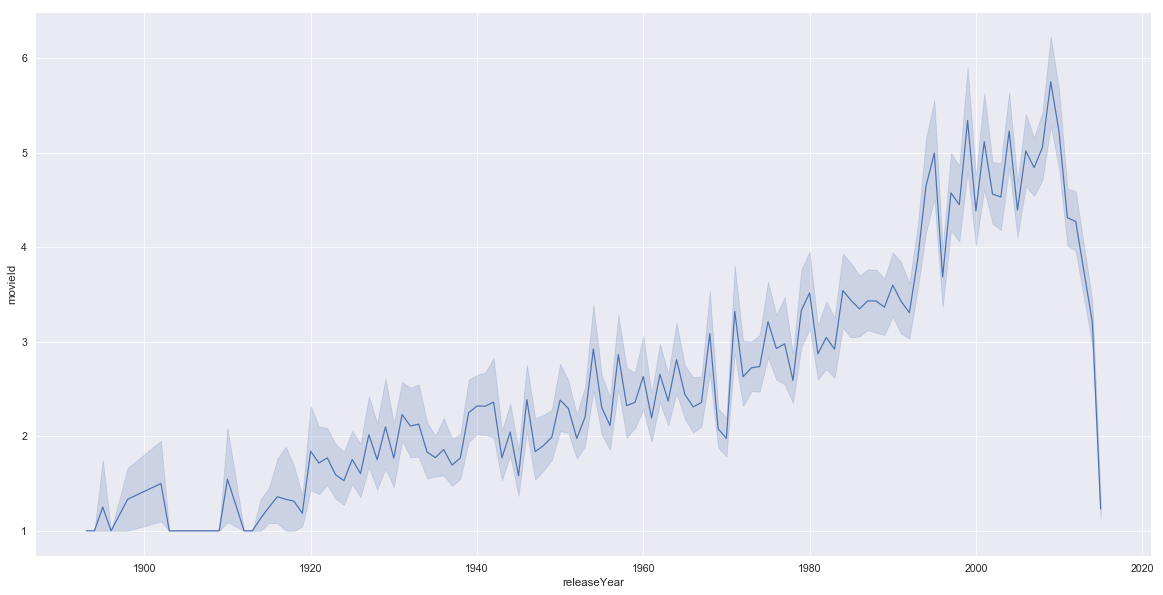

In [11]:
sns.lineplot(x='releaseYear', y='movieId', data=tag_year_counts)
plt.show()

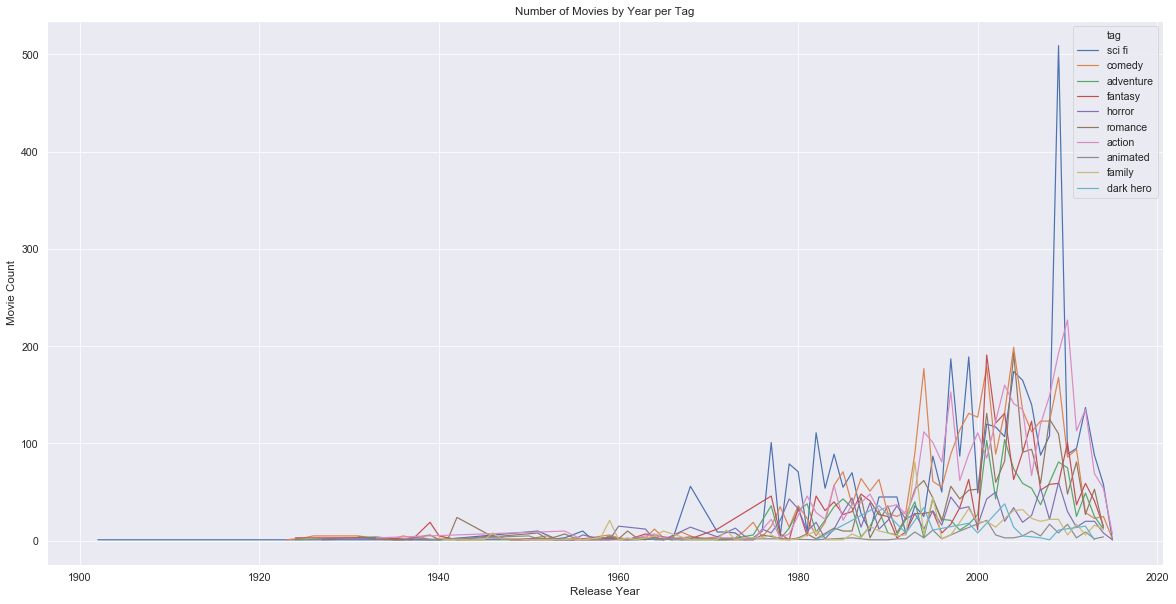

In [12]:
tags_of_interest = ['comedy', 'horror', 'adventure', 'action', 'sci fi', 'romance', 'family', 'animated', 'dark hero', 'fantasy']

sns.lineplot(x='releaseYear', y='movieId', data=tag_year_counts[tag_year_counts['tag'].isin(tags_of_interest)], hue='tag')
_ = plt.xlabel('Release Year')
_ = plt.ylabel('Movie Count')
_ = plt.title('Number of Movies by Year per Tag')
plt.show()

In [36]:
# Gore movies per year 
gore_movies = tag_year_counts[tag_year_counts['tag']=='gore']
gore_movies['releaseYear'] = gore_movies.releaseYear.astype(object)


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


releaseYear
1973.0    1
1974.0    2
1975.0    1
1978.0    2
1979.0    3
Name: movieId, dtype: int64

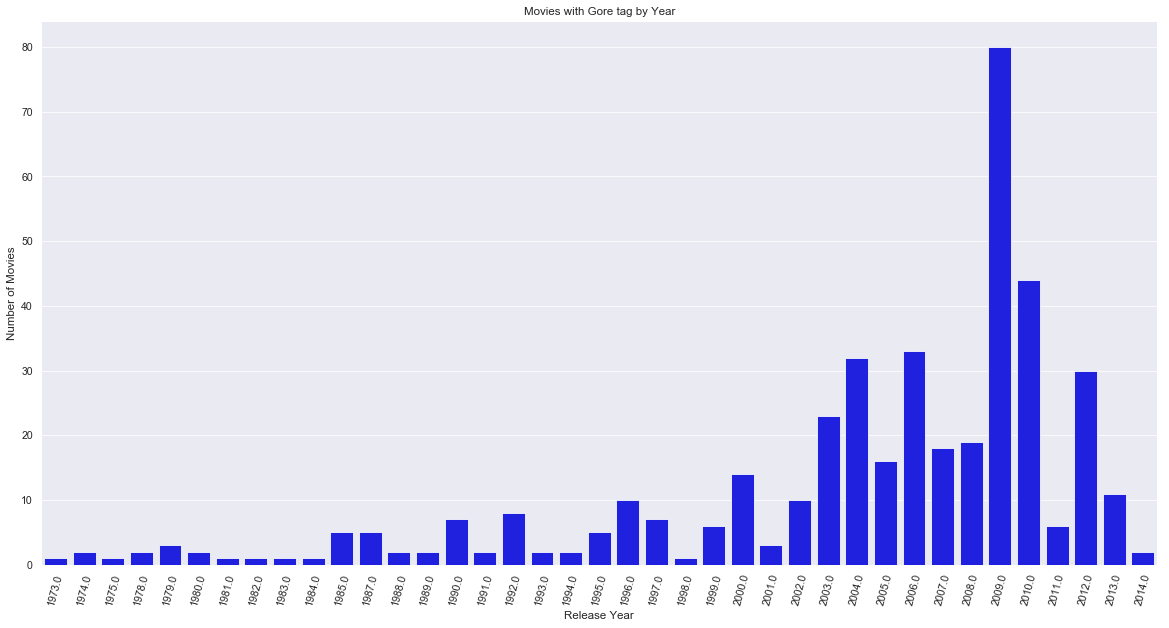

In [44]:
sns.barplot(x='releaseYear', y='movieId', data=gore_movies, color='blue')
_ = plt.xlabel('Release Year')
_ = plt.ylabel('Number of Movies')
_ = plt.title('Movies with Gore tag by Year')
_ = plt.xticks(rotation=75)
plt.show()

There are many tags that rise and fall each year; there's no consistent pattern that a type of movie appears or not. Then again, these are main tags, other tags, like Gore, dissapear and reappear every now and then.  
We'll now move on to doing some Market-Basket Analysis.

In [58]:
# Keep movieId and tag columns to create basket 
tag_pivot = tags[['movieId', 'tag', 'userId']]
tag_pivot = tag_pivot.groupby(['movieId', 'tag'])['userId'].count().reset_index()
tag_pivot.head()

,movieId,tag,userId
0,1,2009 reissu in stereoscop 3 d,1
1,1,3d,3
2,1,55 movi everi kid should see entertain weekli,1
3,1,action figur,2
4,1,adventur,10


In [59]:
# Pivot table to do market basket
tag_pivot2 = tag_pivot.pivot(index='movieId', columns='tag', values='userId').fillna(0)
tag_pivot2.head()

tag,,0 star,007,007 movi are bad,007 seri,01 02 05,01 03 06,01 04 06,01 10,01 10 05,...,çagan irmak,çagatay tosun,é ä é,étienn chatiliez,éva gárdo,î î î½î î¹ îµî¾î î¹ï îµï î¹îºî î î¹îµïƒï ï î î¼î î½î,ömer faruk sorak,özer kiziltan,özgür yildirim,ø ø ø³ø ø³ø øªùš
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

tag_sets = tag_pivot2.applymap(encode_units)

In [61]:
tag_sets.head()

tag,,0 star,007,007 movi are bad,007 seri,01 02 05,01 03 06,01 04 06,01 10,01 10 05,...,çagan irmak,çagatay tosun,é ä é,étienn chatiliez,éva gárdo,î î î½î î¹ îµî¾î î¹ï îµï î¹îºî î î¹îµïƒï ï î î¼î î½î,ömer faruk sorak,özer kiziltan,özgür yildirim,ø ø ø³ø ø³ø øªùš
movieId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
frequent_itemsets = apriori(tag_sets, min_support=0.01, use_colnames=True)

In [68]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(adapt from book ),(base on a book ),0.030852,0.061755,0.022001,0.713101,11.547276,0.020095,3.270299
1,(base on a book ),(adapt from book ),0.061755,0.030852,0.022001,0.356255,11.547276,0.020095,1.505485
2,(bd r ),(clv ),0.119110,0.061294,0.011870,0.099656,1.625863,0.004569,1.042608
3,(clv ),(bd r ),0.061294,0.119110,0.011870,0.193656,1.625863,0.004569,1.092450
4,(bd r ),(criterion ),0.119110,0.046303,0.017038,0.143041,3.089217,0.011522,1.112885


In [72]:
rules[(rules['lift'] >= 2) & (rules['confidence'] >= 0.25)].sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
9,(clearplay ),(r ),0.014531,0.026963,0.014326,0.985915,36.564930,0.013934,69.085597
8,(r ),(clearplay ),0.026963,0.014531,0.014326,0.531309,36.564930,0.013934,2.102601
0,(adapt from book ),(base on a book ),0.030852,0.061755,0.022001,0.713101,11.547276,0.020095,3.270299
1,(base on a book ),(adapt from book ),0.061755,0.030852,0.022001,0.356255,11.547276,0.020095,1.505485
12,(tumey s dvd ),(erlend s dvd ),0.032745,0.037606,0.011051,0.337500,8.974745,0.009820,1.452671
13,(erlend s dvd ),(tumey s dvd ),0.037606,0.032745,0.011051,0.293878,8.974745,0.009820,1.369812
10,(comedi ),(funni ),0.040573,0.037145,0.012484,0.307692,8.283535,0.010977,1.390790
11,(funni ),(comedi ),0.037145,0.040573,0.012484,0.336088,8.283535,0.010977,1.445112
5,(criterion ),(bd r ),0.046303,0.119110,0.017038,0.367956,3.089217,0.011522,1.393716
7,(erlend s dvd ),(bd r ),0.037606,0.119110,0.010079,0.268027,2.250254,0.005600,1.203447


Maybe grouping by tags was not the best idea. There are too many tags and some have too many words to say the same thing (i.e Bond and Jame Bond are two separate tags!). We'll try again with Genres. 

In [87]:
# Split genre into multiple columns
movies['g1'], movies['g2'], movies['g3'], movies['g4'], movies['g5'], movies['g6'], movies['g7'], movies['g8'], movies['g9'], movies['g10'] = movies['genres'].str.split('\|', 9).str

# drop genres
movies = movies.drop('genres', axis = 1)
movies.head()

,movieId,title,releaseYear,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10
0,1,Toy Story,1995,Adventure,Animation,Children,Comedy,Fantasy,NaN,NaN,NaN,NaN,NaN
1,2,Jumanji,1995,Adventure,Children,Fantasy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Grumpier Old Men,1995,Comedy,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Waiting to Exhale,1995,Comedy,Drama,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Father of the Bride Part II,1995,Comedy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
# Group columns
genre_columns = list(movies.loc[:, 'g1':'g10'])
movie_columns = list(movies.loc[:, 'movieId':'releaseYear'])

# unpivot/melt data
movies_melt = pd.melt(movies, id_vars = movie_columns, value_vars = genre_columns)

In [93]:
movies_melt['value'] = movies_melt['value'].str.lower()
movies_melt['genre_flag'] = 1
movies_melt.head()

,movieId,title,releaseYear,variable,value,genre_flag
0,1,Toy Story,1995,g1,adventure,1
1,2,Jumanji,1995,g1,adventure,1
2,3,Grumpier Old Men,1995,g1,comedy,1
3,4,Waiting to Exhale,1995,g1,comedy,1
4,5,Father of the Bride Part II,1995,g1,comedy,1


In [94]:
# new column for each genre
movies2 = movies_melt.groupby(['movieId', 'title', 'releaseYear', 'value'])['genre_flag'].count().unstack('value').reset_index()
movies2 = movies2.fillna(0)
movies2.head()

value,movieId,title,releaseYear,(no genres listed),action,adventure,animation,children,comedy,crime,...,film-noir,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western
0,1,Toy Story,1995,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,1995,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,1995,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,1995,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,1995,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Before movieng on, we need to drop the `title` and `releaseYear` columns. Then, the `movieId` column needs to be made the index of this new dataframe.

In [102]:
movies2 = movies2.set_index('movieId')

In [103]:
movies2.head()

value,(no genres listed),action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film-noir,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western
movieId,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, to do the Market-Basket analysis (and come up with a good pun for the presentation.)

In [124]:
movies = movies.fillna(0)

,movieId,title,releaseYear,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10
0,1,Toy Story,1995,Adventure,Animation,Children,Comedy,Fantasy,0,0,0,0,0
1,2,Jumanji,1995,Adventure,Children,Fantasy,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,Comedy,Romance,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale,1995,Comedy,Drama,Romance,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,1995,Comedy,0,0,0,0,0,0,0,0,0


In [159]:
test = pd.DataFrame(movies.iloc[0, 3:])
test2 = test[test.iloc[:, 0]!=0]
list(test2.iloc[:, 0].T)

['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy']

In [160]:
movies_list = []

for i in range(len(movies)):
    step1 = pd.DataFrame(movies.iloc[i, 3:])
    step2 = step1[step1.iloc[:, 0]!=0]
    step3 = list(step2.iloc[:, 0].T)
    movies_list.append(step3)
    
movies_list[:5]

[['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'],
 ['Adventure', 'Children', 'Fantasy'],
 ['Comedy', 'Romance'],
 ['Comedy', 'Drama', 'Romance'],
 ['Comedy']]

In [161]:
te = TransactionEncoder()
te_ary = te.fit(movies_list).transform(movies_list)

In [162]:
df = pd.DataFrame(te_ary, columns=te.columns_)
df.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,False,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [165]:
frequent_genres = apriori(df, min_support=0.0005, use_colnames=True, max_len=3)

In [167]:
rules = association_rules(frequent_genres, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Adventure),(Action),0.085458,0.129123,0.035666,0.417347,3.232152,0.024631,1.494673
1,(Action),(Adventure),0.129123,0.085458,0.035666,0.276215,3.232152,0.024631,1.263554
2,(Animation),(Action),0.037684,0.129123,0.007265,0.192795,1.493103,0.002399,1.078878
3,(Action),(Animation),0.129123,0.037684,0.007265,0.056266,1.493103,0.002399,1.019690
4,(Crime),(Action),0.107805,0.129123,0.028144,0.261062,2.021802,0.014224,1.178552


In [177]:
rules[(rules['support']>=.01) & (rules['lift']>=2)].sort_values(['lift', 'confidence'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
32,(Animation),(Children),0.037684,0.041794,0.017246,0.457644,10.950098,0.015671,1.766747
33,(Children),(Animation),0.041794,0.037684,0.017246,0.412643,10.950098,0.015671,1.638383
46,(Children),(Fantasy),0.041794,0.051774,0.011412,0.273047,5.273804,0.009248,1.304383
47,(Fantasy),(Children),0.051774,0.041794,0.011412,0.220411,5.273804,0.009248,1.229118
21,(Children),(Adventure),0.041794,0.085458,0.016512,0.395083,4.623104,0.012940,1.511847
20,(Adventure),(Children),0.085458,0.041794,0.016512,0.193216,4.623104,0.012940,1.187686
23,(Fantasy),(Adventure),0.051774,0.085458,0.018750,0.362155,4.237783,0.014326,1.433798
22,(Adventure),(Fantasy),0.085458,0.051774,0.018750,0.219407,4.237783,0.014326,1.214751
18,(Adventure),(Animation),0.085458,0.037684,0.012916,0.151138,4.010671,0.009696,1.133654
19,(Animation),(Adventure),0.037684,0.085458,0.012916,0.342746,4.010671,0.009696,1.391458
